In [1]:
import ElecResponse, responses, numpy as np, matplotlib.pyplot as plt, torch, h5py as h5

In [2]:
#Load field response from garfield file
field_response = responses.load('dune-garfield-1d565.json.bz2')

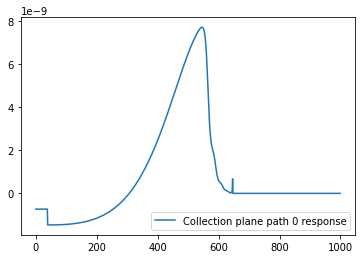

In [3]:
#Plot current in a collection wire from one electron path 
plt.plot(field_response.planes[2].paths[0].current, label='Collection plane path 0 response'); plt.legend()

In [4]:
#Make an electronics response instance, defined by gain and shaping time
elec_response_for_field = ElecResponse.ElecResponse(14., 2.)

In [5]:
#Make an electronics response in the same coarseness
#of the field response.
#Unit of period is ns, shaping time is us
current = field_response.planes[2].paths[0].current
the_response = elec_response_for_field(
    torch.Tensor(
        np.linspace(0, 
                    1e-3*field_response.period*len(current),
                    len(current)
                   )
    )
)

In [6]:
scale_factor = ((1 << 12) - 1) / 1.4e3 #ADC / mV 

In [7]:
scale_factor

2.925

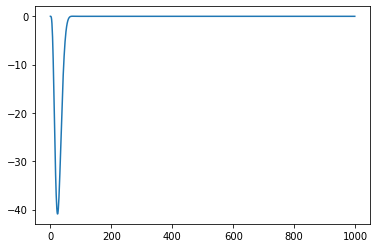

In [8]:
plt.plot((the_response * -1* scale_factor))

In [9]:
#Plot the scaled electronics response in freq domain

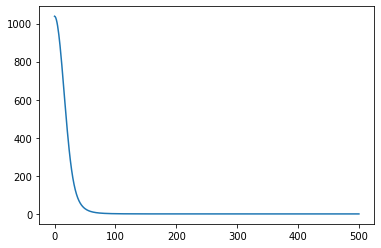

In [10]:
fftd_elec_response = torch.fft.rfft(the_response * -1* scale_factor)
plt.plot(torch.sqrt(fftd_elec_response.real**2 + fftd_elec_response.imag**2))

In [11]:
#Average over the paths for each wire region
avg_response = responses.wire_region_average(field_response)

In [12]:
avg_response_tensor = avg_response.as_tensor()

In [13]:
plane2_avg_response = avg_response_tensor[2]

In [14]:
#FFT the plane 2 response
fftd_plane2_avg_response = torch.fft.rfft(plane2_avg_response, axis=1)

In [15]:
#Combine electronics and field responses then do inverse FFT
field_and_elec = torch.fft.irfft(
    (fftd_plane2_avg_response*
     fftd_elec_response*
     avg_response.period*1.e-3), axis=1
)

In [16]:
#Show the electronics x field response in 'log10 scale'
modded = torch.zeros_like(field_and_elec)
good_vals = field_and_elec[torch.where(torch.abs(field_and_elec) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

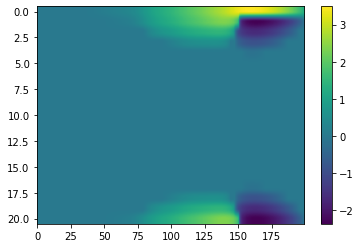

In [17]:
plt.imshow(modded[:,500:700], aspect='auto'); plt.colorbar()

In [18]:
#This is just for demonstration over the entire set of paths 
plane2_response = field_response.as_tensor()[2]
fftd_plane2_response = torch.fft.rfft(plane2_response, axis=1)

In [19]:
# Combining field and electronics response
field_and_elec_full = torch.fft.irfft(
    fftd_plane2_response*fftd_elec_response*1.e-3*field_response.period,
    axis=1
)

In [20]:
#log 10 scale
modded = torch.zeros_like(field_and_elec_full)
good_vals = field_and_elec_full[torch.where(torch.abs(field_and_elec_full) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec_full) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

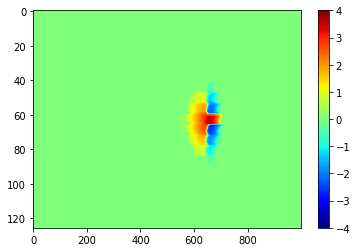

In [21]:
plt.imshow(modded, aspect='auto', vmin=-4, vmax=4, cmap='jet'); plt.colorbar()

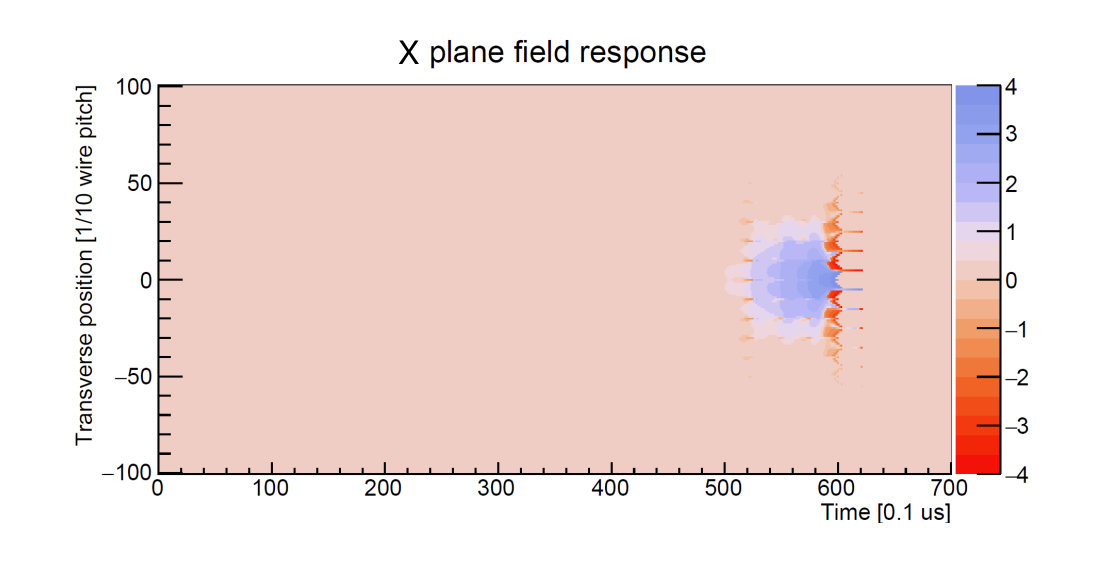

In [22]:
#From PDSP performance paper
from IPython.display import Image
Image("/home/jake/Documents/collection.png")

In [23]:
#Load rawdigits from PDSP simulation
f = h5.File('pdsp_wires.h5')
wires = torch.Tensor(f['wires'][0])

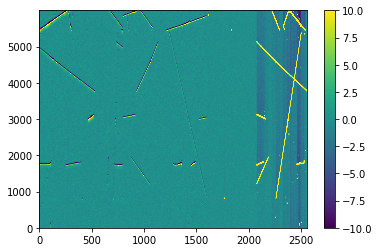

In [24]:
plt.imshow((wires.T - torch.mean(wires, axis=1)), aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [25]:
#Getting the collection plane wires and removing pedestal
coll = torch.Tensor(wires[-480:].T - torch.mean(wires[-480:], axis=1)).T

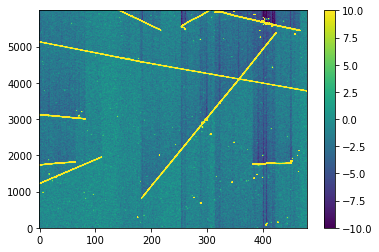

In [26]:
plt.imshow(coll.T, aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [27]:
#Redigitize field x electronics response into the same 
redigit = responses.redigitize(field_and_elec, 100*1e-3, .5, 6000)

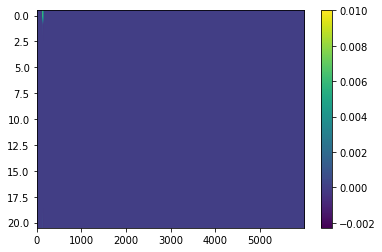

In [28]:
plt.imshow(redigit, aspect='auto', vmax=.01); plt.colorbar()

In [29]:
#FFT redigitized response in both domains
redigit_fftd = torch.fft.fft(torch.fft.rfft(redigit,axis=1), axis=0)

In [30]:
#FFT raw digits in both domains
coll_fftd = torch.fft.fft(torch.fft.rfft(coll,axis=1), axis=0)

In [31]:
#Padd out the redigitized response to match wire width
#then FFT in both domains
padded = torch.zeros_like(coll)
padded[:21] = redigit
padded_fft = torch.fft.fft(torch.fft.rfft(padded, axis=1), axis=0)

In [32]:
#Apply response to fftd raw digits
responsed = coll_fftd/padded_fft

In [33]:
#Make a filter for wire dimension
filter_vals = np.zeros(480)
filter_vals[:240] = np.linspace(0, 1, 240)
filter_vals[240:] = np.linspace(0, 1, 240)[::-1]
filter_vals = np.exp(-.5*(filter_vals/np.sqrt(np.pi))**2)

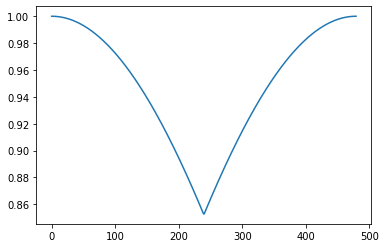

In [34]:
plt.plot(filter_vals)

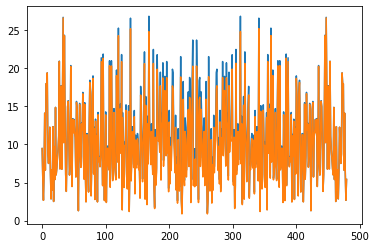

In [35]:

plt.plot(torch.abs(responsed.T[0]))
plt.plot(torch.abs(responsed.T[0])*filter_vals)

In [36]:
#Apply filter, then do inverse FFTs in both directions 
output = torch.fft.irfft(
    torch.fft.ifft(
        (responsed.T*filter_vals).T,
        axis=0
    ),
    axis=1
)

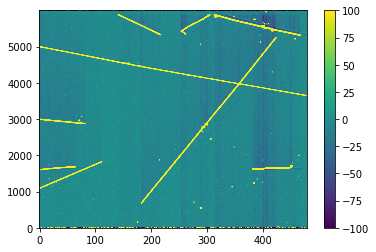

In [58]:
plt.imshow(output.T, aspect='auto', vmin=-100, vmax=100, origin='lower'); plt.colorbar();